# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML
from matplotlib import pyplot as plt


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

# For collecting results to configure pytest tests

In [3]:
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE
from large_gcs.graph.graph import ShortestPathSolution


graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_trichal2")
# cg = ContactGraph.load_from_file(graph_file)
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=False,
    should_add_gcs=False,
)
cost_estimator = FactoredCollisionFreeCE(
    cg,
    use_combined_gcs=False,
    add_transition_cost=True,
    obj_multiplier=100.0,
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol: ShortestPathSolution = gcs_astar.run()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 5149.54it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9586.98it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 56.22it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (100)
100%|██████████| 100/100 [00:00<00:00, 705.09it/s]
INFO:large_gcs.cost_estimators.factored_collision_free_ce:creating 2 collision free graphs...
0it [00:00, ?it/s]INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 8/8 [00:00<00:00, 10679.32it/s]
INFO:large_gcs.graph.graph:Adding 8 vertices to graph...
100%|██████████| 8/8 [00:00<00:00, 15148.73it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 28/28 [00:00<00:00, 721.94it/s]
INFO:large_gcs.graph.

In [8]:
str(sol)

14.577507492280892
['source', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')", "('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f2-rob0_f2')", "('NC|obs0_v0-obj0_f2', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f0-rob0_v1', 'IC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f1-rob0_f1')", "('NC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f1-rob0_f1')", "('NC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'NC|obj0_f1-rob0_f1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_v0-rob0_f0', 'IC|obj0_f0-rob0_v1')", "('IC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')", "('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'IC|obj0_f0-rob0_v1')", "('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'NC|obj0_v0-rob0_f0')", 'target']
[3.250, 0.000, 1.500, 0.500],[3.250, 3.250, 0.000,

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

# Simple Demo

## Simple Demo 2

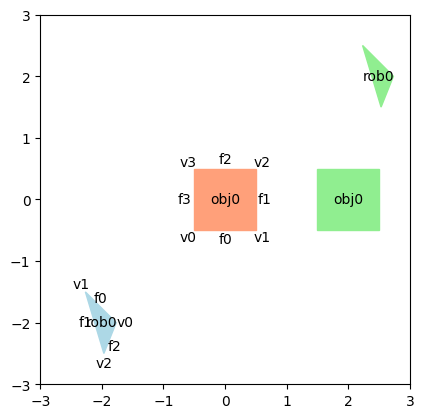

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 95.05it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 14 sets...
100%|██████████| 14/14 [00:00<00:00, 19.94it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 14/14 [00:00<00:00, 324.90it/s]
INFO:large_gcs.graph.contact_graph:14 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 16/16 [00:00<00:00, 18461.86it/s]
INFO:large_gcs.graph.graph:Adding 16 vertices to graph...
100%|██████████| 16/16 [00:00<00:00, 27324.46it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 120/120 [00:00<00:00, 3696.02it/s]
INFO:large_gcs.graph.contact_graph:100 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 100/100 [00:00<00:00, 19701.74it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints

In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 109.71it/s]
INFO:large_gcs.graph.contact_graph:Loading 14 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 14 sets...
100%|██████████| 14/14 [00:00<00:00, 20.51it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 16/16 [00:00<00:00, 20207.43it/s]
INFO:large_gcs.graph.graph:Adding 16 vertices to graph...
100%|██████████| 16/16 [00:00<00:00, 21297.64it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 100/100 [00:00<00:00, 13629.82it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 100/100 [00:00<00:00, 10546.40it/s]
INFO:large_gcs.graph.graph:Adding 100 edges to graph...
100%|██████████| 100/100 [00:00<00:00, 10117.97it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 15), n_vertices=16, n_e

In [5]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 74235.47it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 28630.06it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 84.70it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (91)
100%|██████████| 91/91 [00:00<00:00, 2866.02it/s]


In [6]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 47934.90it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 28728.11it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 109.46it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (91)
100%|██████████| 91/91 [00:00<00:00, 3152.99it/s]


### Testing solution methods

In [5]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 2}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 3}, n_vertices_visited: {0: 2}, time_wall_clock: 0.0277, n_gcs_solves: 2, gcs_solve_time_total: 0.00354, gcs_solve_time_iter_mean: 0.00177, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0.000858, gcs_solve_time_iter_min: 0.000912, gcs_solve_time_iter_max: 0.00263, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node ('NC|obj0_f

In [ ]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under
)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=True)
print(sol)

## Simple Demo 3 (Target Region)

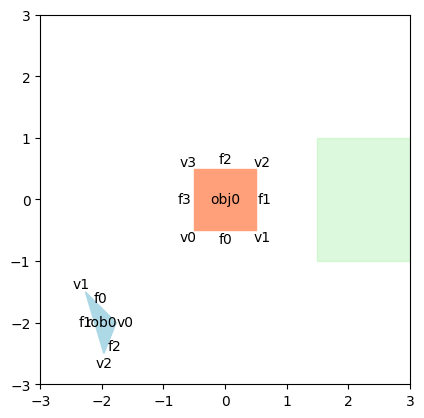

In [7]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [8]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 94.14it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 14 sets...
100%|██████████| 14/14 [00:00<00:00, 20.71it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 14/14 [00:00<00:00, 339.82it/s]
INFO:large_gcs.graph.contact_graph:14 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 16/16 [00:00<00:00, 20244.00it/s]
INFO:large_gcs.graph.graph:Adding 16 vertices to graph...
100%|██████████| 16/16 [00:00<00:00, 21767.39it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 120/120 [00:00<00:00, 3972.76it/s]
INFO:large_gcs.graph.contact_graph:112 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 112/112 [00:00<00:00, 19705.61it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints

In [10]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 61230.72it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 28149.69it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 108.53it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (91)
100%|██████████| 91/91 [00:00<00:00, 2737.95it/s]


In [11]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 33288.13it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 19195.90it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 106.62it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (91)
100%|██████████| 91/91 [00:00<00:00, 3558.41it/s]


In [14]:
cost_estimator = ShortcutEdgeCE(
    cg_inc,
    shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted,
)
gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 2}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node source's 1 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 3}, n_vertices_visited: {0: 1}, time_wall_clock: 0.0141, n_gcs_solves: 1, gcs_solve_time_total: 0.000847, gcs_solve_time_iter_mean: 0.000847, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: 0.000847, gcs_solve_time_iter_max: 0.000847, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node ('NC|obj0_f0-ro

# Triangle Challenge

## Triangle Challenge 2

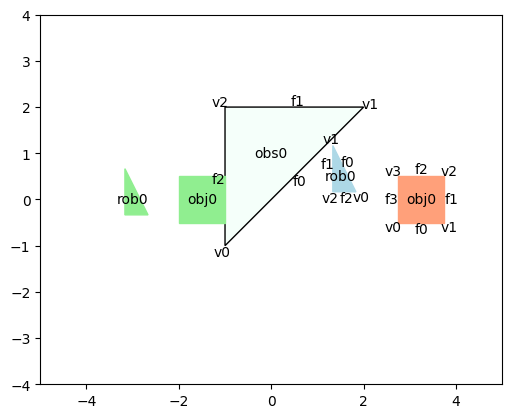

In [18]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [17]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.55it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 445.61it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3661.28it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11193.55it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 12086.75it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 7004.02it/s]
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6651.01it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [19]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 66.06it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 519.84it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11854.61it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 10252.94it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6184.38it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 3983.96it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 5402.74it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vert

In [19]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12446.01it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5507.95it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.62it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 6708.00it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 35394.97it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 74.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 8442.29it/s]


### Testing solution methods

In [20]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(
    logging.DEBUG
)
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 2}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.2600165443413, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 3}, n_vertices_visited: {0: 1}, time_wall_clock: 0.0147, n_gcs_solves: 1, gcs_solve_time_total: 0.000844, gcs_solve_time_iter_mean: 0.000844, gcs_solve_time_last_10_mean

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2243lae7/temp.m4v


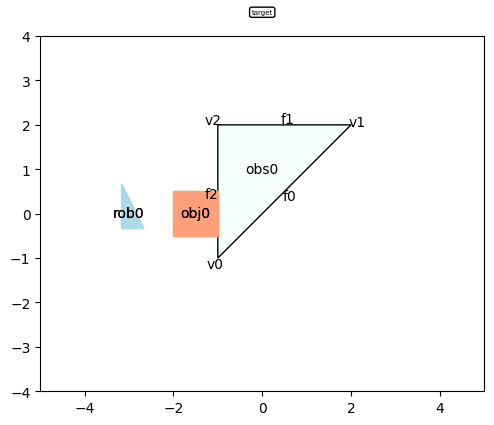

In [9]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

## Triangle Challenge 3

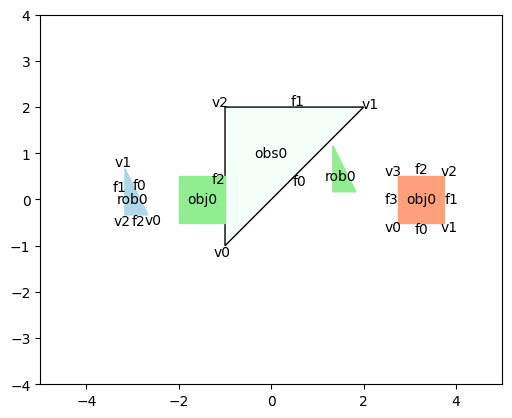

In [14]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [15]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.50it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:04<00:00, 47.13it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3896.61it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 8314.83it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 10678.38it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
  0%|          | 10/16290 [00:03<1:02:43,  4.33it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

100%|██████████| 16290/16290 [00:04<00:00, 3499.24it/s] 
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8167.36it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4578.96it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 4101.30it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6120, source=[array([3.250, 0.000]), array([-3,  0])], target=[array([-1.500, 0.000]), array([1.500, 0.500])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [16]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 41734.37it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17697.49it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 58.42it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:03<00:00, 20.34it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28630.06it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15505.74it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 54.36it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:03<00:00, 18.54it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use on

In [17]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.90it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:03<00:00, 46.40it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 9231.93it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9586.92it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8313.60it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4272.01it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 3607.70it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertice

In [24]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9372.75it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.39it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 12777.63it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 32388.45it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 21732.15it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.51it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 5868.00it/s]


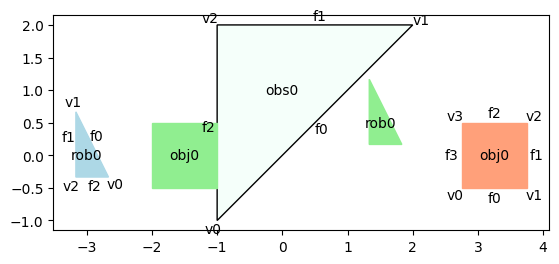

In [18]:
cg_inc.plot()

## Triangle Challenge 4 (Target Region)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


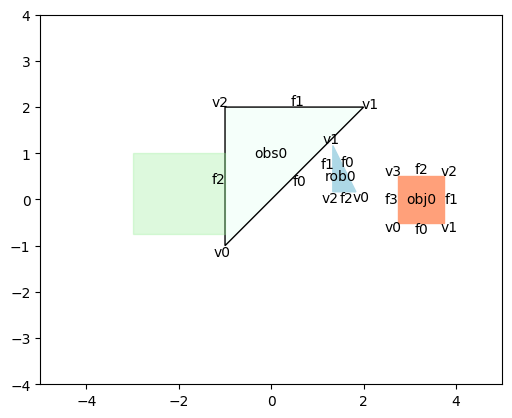

In [2]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-3, -0.75], [-3, 1], [-1, -0.75], [-1, 1]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.65it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 460.45it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3884.45it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10436.32it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 13054.91it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 6977.31it/s]
INFO:large_gcs.graph.contact_graph:6145 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6145/6145 [00:00<00:00, 9251.84it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [4]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 34521.02it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15947.92it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 67.52it/s]


INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 5812.41it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 15420.24it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 18396.07it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 68.53it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 7629.73it/s]


## Trichal 5-15

In [29]:
seed = 0
ws_x = 5
ws_y = 4
bl = np.array([-ws_x, -ws_y])
tr_width = 1.5
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
generators = []
i = 0
while len(generators) < 10:
    i += 1
    np.random.seed(seed + i)
    target_region_offset = np.random.uniform(
        [0, 0], [2 * ws_x - tr_width, 2 * ws_y - tr_width]
    )
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices + target_region_offset,
            obj_indices=[0],
        ),
    ]
    buffer = 2
    body_offsets = np.random.uniform(
        [-ws_x + buffer, -ws_y + buffer], [ws_x - buffer, ws_y - buffer], size=(2, 2)
    )

    params = ContactGraphGeneratorParams(
        name="cg_trichal" + str(len(generators) + 5),
        obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2) + body_offsets[0]],
        source_rob_pos=[np.zeros(2) + body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
    # generator.plot()
    # plt.show()

1
2
3
4
5
6
7
8
9
10


In [30]:
for i, generator in enumerate(generators):
    # generator.plot()
    # plt.show()
    generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 46603.38it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...


100%|██████████| 2/2 [00:00<00:00, 13025.79it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 56.67it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 766.50it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 21788.59it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20763.88it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 72.48it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 686.54it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 48210.39it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:0

# Maze a

## Maze a1

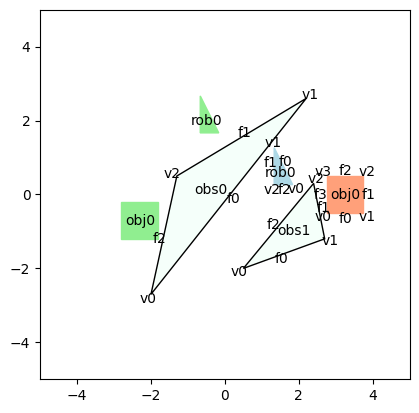

In [3]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [4]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 55.78it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 70560 sets...
  5%|▌         | 3545/70560 [00:08<02:57, 378.49it/s]

KeyboardInterrupt: 

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [5]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 29852.70it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 14742.72it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 54.20it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 772.60it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 45590.26it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13378.96it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 63.07it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 745.80it/s]


  5%|▌         | 3545/70560 [00:19<02:57, 378.49it/s]

## Maze a2

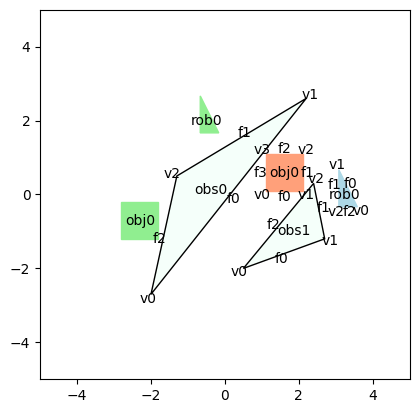

In [4]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [30]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.60it/s]
INFO:large_gcs.graph.contact_graph:Loading 35 contact pair modes for 4 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 836 sets...
100%|██████████| 836/836 [00:02<00:00, 414.74it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 838/838 [00:00<00:00, 11124.70it/s]
INFO:large_gcs.graph.graph:Adding 838 vertices to graph...
100%|██████████| 838/838 [00:00<00:00, 10377.68it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 29994/29994 [00:03<00:00, 8018.75it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 29994/29994 [00:05<00:00, 5015.83it/s]
INFO:large_gcs.graph.graph:Adding 29994 edges to graph...
100%|██████████| 29994/29994 [00:06<00:00, 4954.37it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18),

In [7]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 13797.05it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13934.56it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 51.05it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 758.88it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28532.68it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 16777.22it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 62.35it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:00<00:00, 770.72it/s]


## Maze a10-a39

1


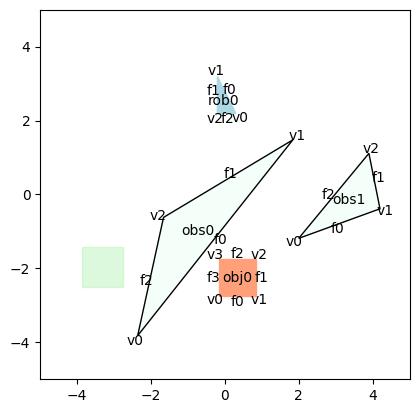

2


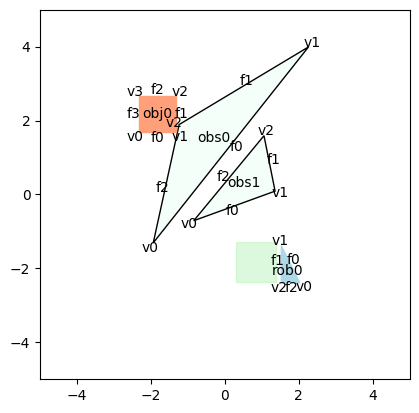

3


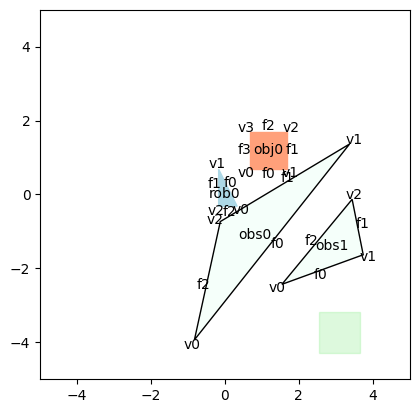

4


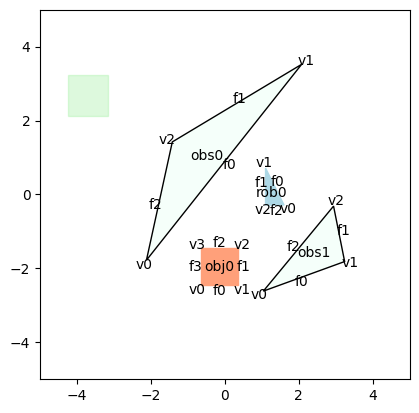

5


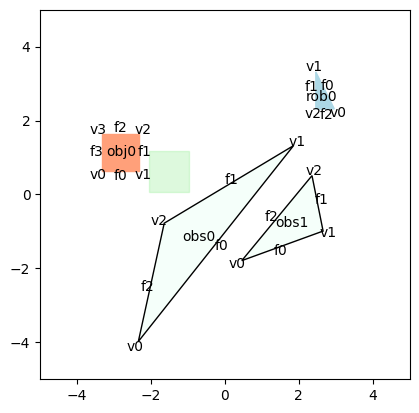

6


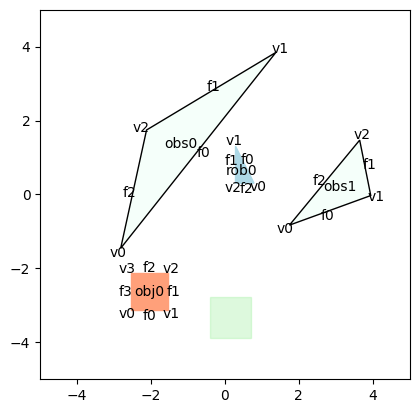

7


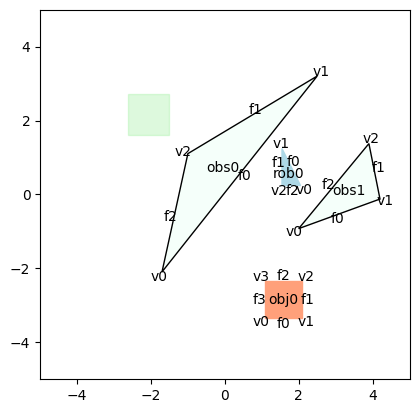

8


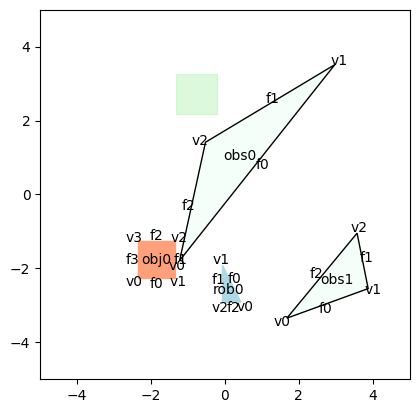

9


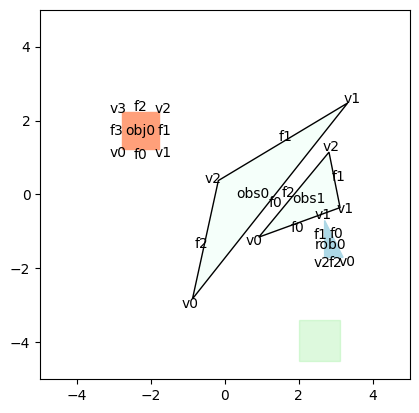

10


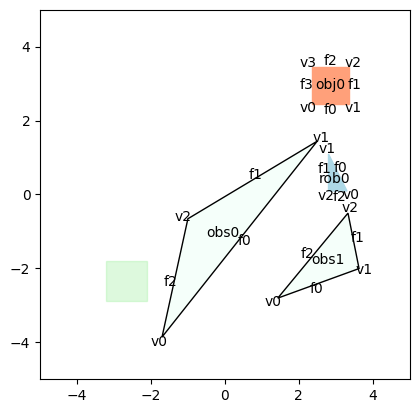

11


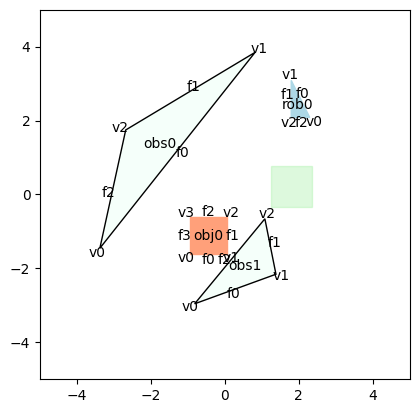

12


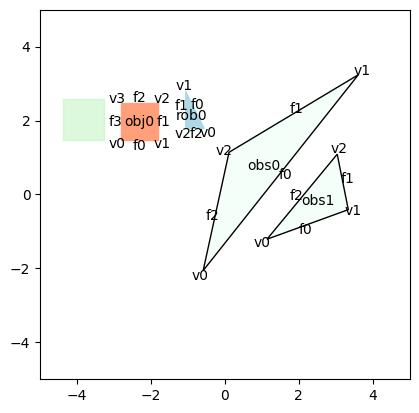

13


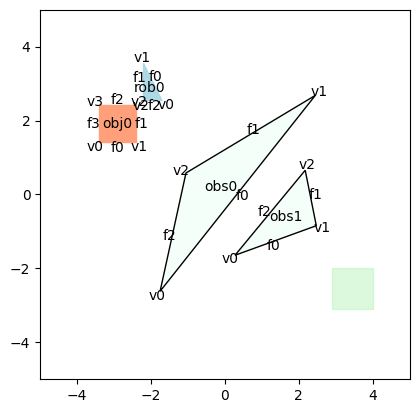

14


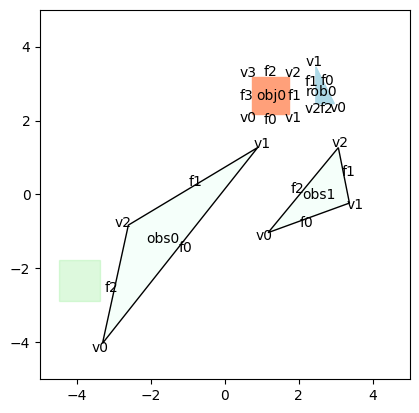

15


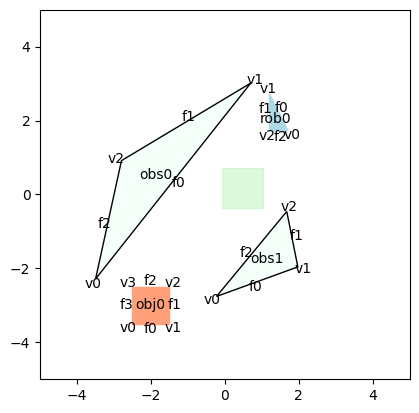

16


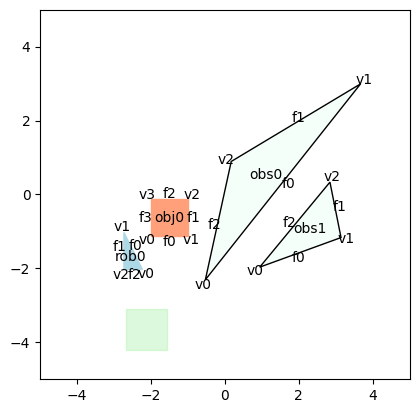

17


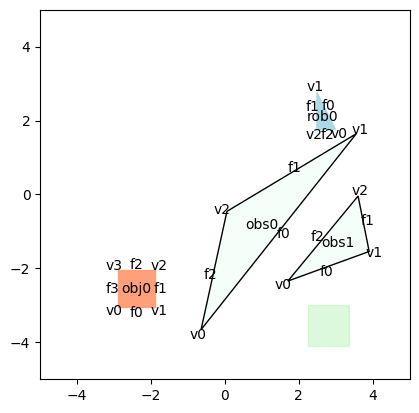

18


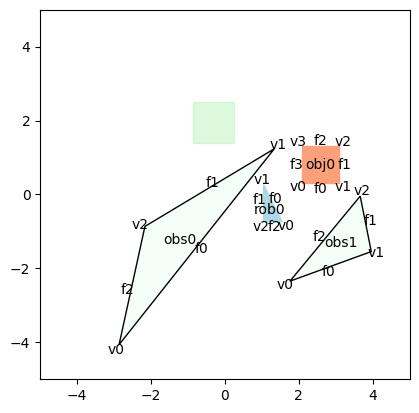

19


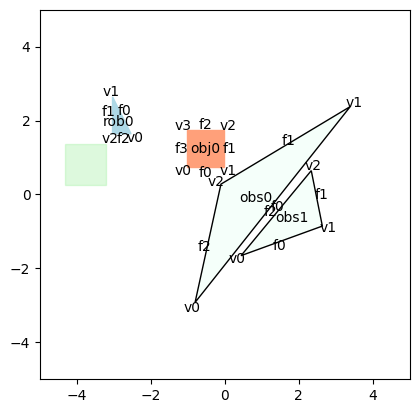

20


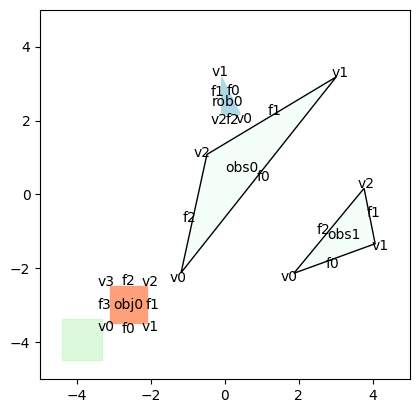

21


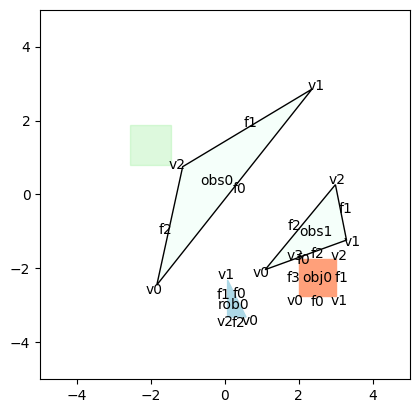

22


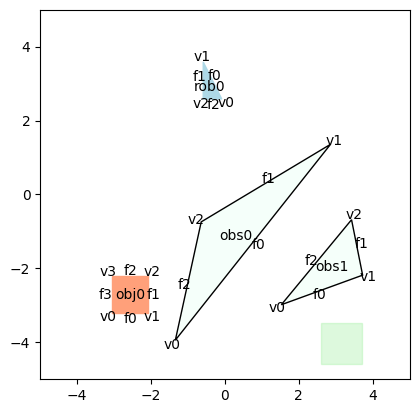

23


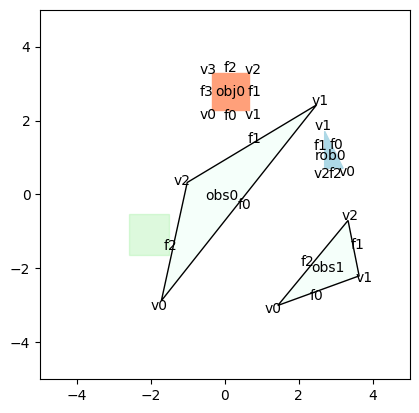

24


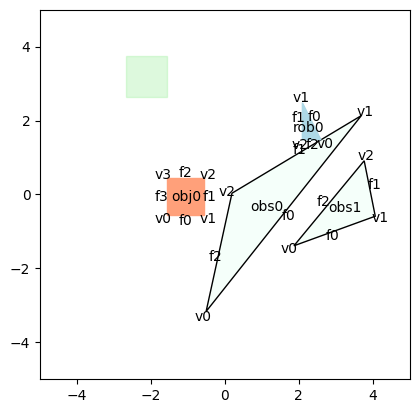

25


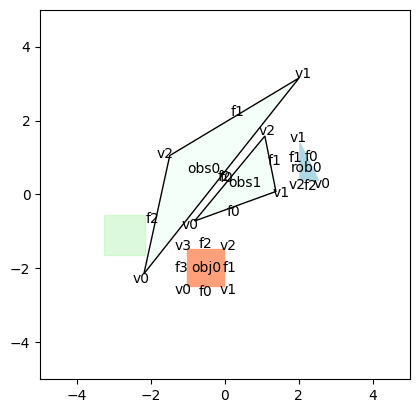

26


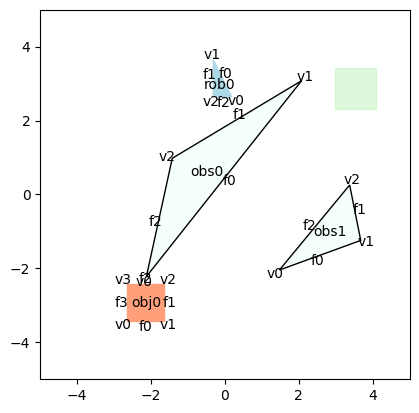

27


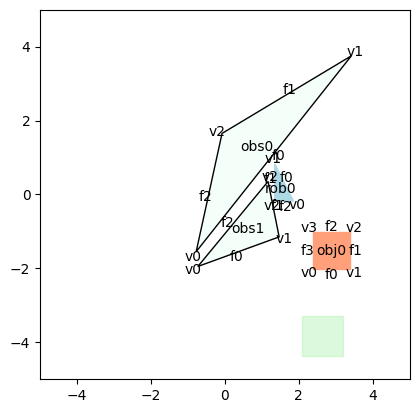

28


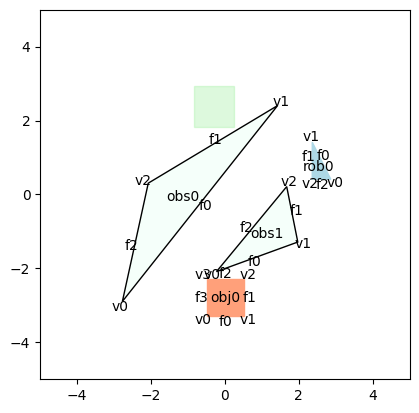

29


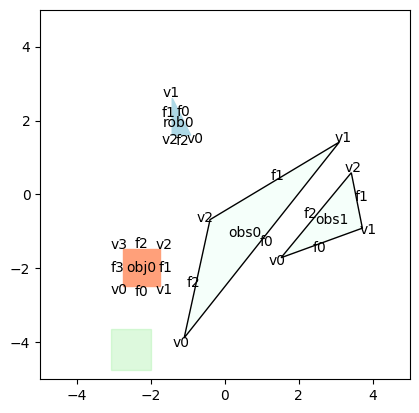

30


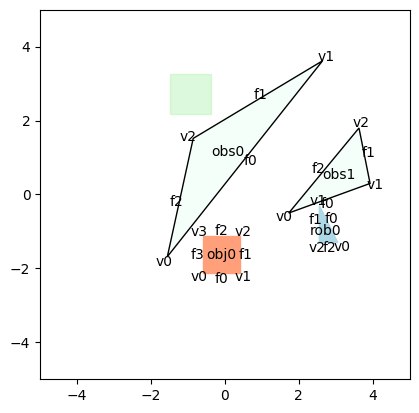

In [3]:
ws_x = 5
ws_y = 5
seed = 123
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
generators = []
i = 0
while len(generators) < 30:
    i += 1
    np.random.seed(seed + i)
    buffer = 2
    target_region_offset = np.random.uniform(
        [0, 0], [2 * ws_x - buffer, 2 * ws_y - buffer]
    )
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices + target_region_offset,
            obj_indices=[0],
        ),
    ]

    body_offsets = np.random.uniform(
        [-ws_x + buffer, -ws_y + buffer], [ws_x - buffer, ws_y - buffer], size=(2, 2)
    )
    obs_offsets = np.random.uniform([-1.5, -1.5], [1.5, 1.5], size=(2, 2))
    obs_a_vertices = np.array([[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]]) + obs_offsets[0]
    obs_b_vertices = np.array([[0.5, -2], [2.7, -1.2], [2.4, 0.3]]) + obs_offsets[1]
    params = ContactGraphGeneratorParams(
        name="cg_maze_a" + str(len(generators) + 10),
        obs_vertices=[
            obs_a_vertices,
            obs_b_vertices,
        ],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2) + body_offsets[0]],
        source_rob_pos=[np.zeros(2) + body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
        generator.plot()
        plt.show()

In [4]:
for i, generator in enumerate(generators):
    if i < 10: continue
    # generator.plot()
    # plt.show()
    print(f"Generating {i}")
    generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...


Generating 10


100%|██████████| 2/2 [00:00<00:00, 21675.99it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7660.83it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 48.12it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:03<00:00, 77.03it/s] 


Generating 11


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 10305.42it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12052.60it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 33.39it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:03<00:00, 64.81it/s] 


Generating 12


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 26379.27it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12427.57it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 31.04it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 62.90it/s] 


Generating 13


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 29026.33it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 13005.59it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 29.53it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 63.24it/s] 


Generating 14


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 27776.85it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12925.44it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 28.09it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 63.74it/s] 


Generating 15


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28926.23it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7516.67it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 29.72it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:03<00:00, 65.01it/s] 


Generating 16


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 26973.02it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 14266.34it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 30.43it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 61.18it/s] 


Generating 17


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 23497.50it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12409.18it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 28.09it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 57.24it/s] 


Generating 18


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 21454.24it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12576.62it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 23.72it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 45.92it/s] 


Generating 19


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 6553.60it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5511.57it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 21.56it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 42.91it/s] 


Generating 20


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 4874.26it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5479.17it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 20.59it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:06<00:00, 41.50it/s] 


Generating 21


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 5599.87it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9478.65it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 16.45it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:06<00:00, 40.87it/s] 


Generating 22


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8027.38it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5970.54it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 21.84it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 49.34it/s] 


Generating 23


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 22250.95it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12336.19it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 25.07it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 53.58it/s] 


Generating 24


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 7876.63it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6408.41it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 23.96it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 53.28it/s] 


Generating 25


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8738.13it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 7194.35it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 24.12it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:04<00:00, 52.88it/s] 


Generating 26


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 7781.64it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6641.81it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 24.01it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 48.75it/s] 


Generating 27


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8035.07it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 10979.85it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 21.30it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 47.99it/s] 


Generating 28


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 5493.52it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5733.84it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 19.09it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 48.11it/s] 


Generating 29


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8648.05it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6004.73it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 22.23it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (257)
100%|██████████| 257/257 [00:05<00:00, 49.51it/s] 


In [5]:
base = "cg_maze_a"
names = [base + str(i) for i in range(20, 40)]
# print without quotes:
print(*names, sep=", ")

cg_maze_a20, cg_maze_a21, cg_maze_a22, cg_maze_a23, cg_maze_a24, cg_maze_a25, cg_maze_a26, cg_maze_a27, cg_maze_a28, cg_maze_a29, cg_maze_a30, cg_maze_a31, cg_maze_a32, cg_maze_a33, cg_maze_a34, cg_maze_a35, cg_maze_a36, cg_maze_a37, cg_maze_a38, cg_maze_a39


# Maze B (Adversarial Feasibility Examples)

These examples are designed to make solving the convex restriction using the shortcut edge heuristic fail because the first path explored is ultimately infeasible.

## b0
This was a failed attempt to generate an adversarial example

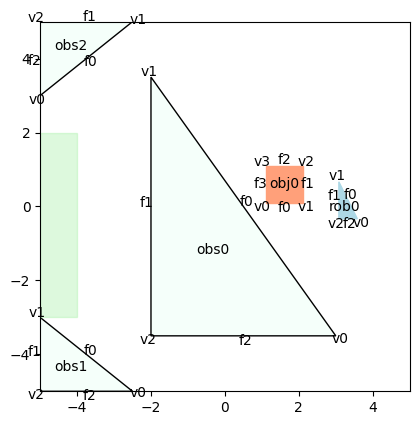

In [28]:
ws_x = 5
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-5, -3], [-4, -3], [-4, 2], [-5, 2]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_maze_b0",
    obs_vertices=[
        [[-2, -3.5], [3, -3.5], [-2, 3.5]],
        [[-5, -5], [-2.5, -5], [-5, -3]],
        [[-5, 5], [-2.5, 5], [-5, 3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [29]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 38657.18it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 22075.28it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 7 body pairs...
100%|██████████| 7/7 [00:00<00:00, 76.04it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (220)
100%|██████████| 220/220 [00:00<00:00, 735.82it/s]


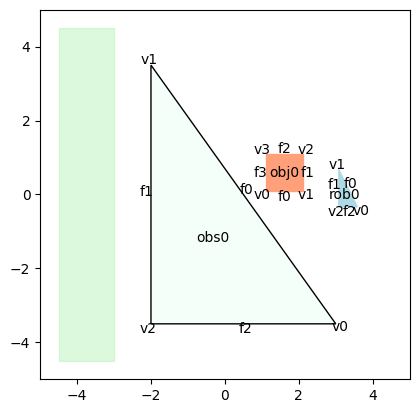

In [13]:
ws_x = 5
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-4.5, -4.5], [-3, -4.5], [-3, 4.5], [-4.5, 4.5]],
        obj_indices=[0],
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_maze_b0_1",
    obs_vertices=[
        [[-2, -3.5], [3, -3.5], [-2, 3.5]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [14]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 31418.01it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 16912.52it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.88it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (105)
100%|██████████| 105/105 [00:00<00:00, 746.16it/s]


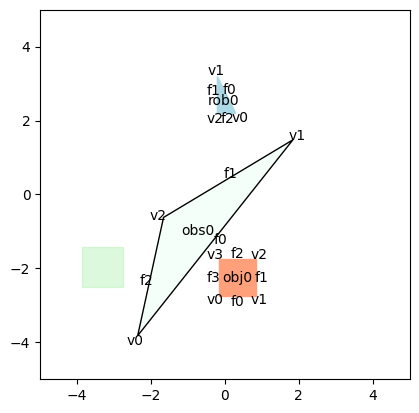

In [3]:
params = ContactGraphGeneratorParams(
    name="cg_maze_b1",
    obs_vertices=[
        [[-2.360, -3.821], [1.840, 1.479], [-1.660, -0.621]],
    ],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[0.329, -2.245]],
    source_rob_pos=[[-0.037, 2.527]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-3.867, -2.508],
                [-2.767, -2.508],
                [-2.767, -1.408],
                [-3.867, -1.408],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

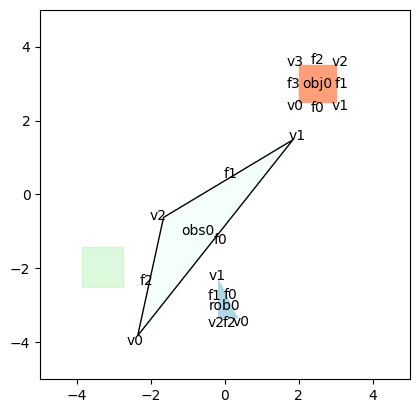

In [33]:
params = ContactGraphGeneratorParams(
    name="cg_maze_b1_1",
    obs_vertices=[
        [[-2.360, -3.821], [1.840, 1.479], [-1.660, -0.621]],
    ],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[2.5, 3]],
    source_rob_pos=[[0, -3]],  # [[4, 3]], #[[-0.037, 2.527]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-3.867, -2.508],
                [-2.767, -2.508],
                [-2.767, -1.408],
                [-3.867, -1.408],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [4]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 53.26it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 840 sets...
100%|██████████| 840/840 [04:13<00:00,  3.32it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 840/840 [00:05<00:00, 151.89it/s]
INFO:large_gcs.graph.contact_graph:626 sets remain after removing 214 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 628/628 [00:00<00:00, 10859.17it/s]
INFO:large_gcs.graph.graph:Adding 628 vertices to graph...
100%|██████████| 628/628 [00:00<00:00, 12735.64it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 196878/196878 [05:02<00:00, 649.99it/s]
INFO:large_gcs.graph.contact_graph:56806 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 56806/56806 [00:07<00:00, 7580.11it/s]
INFO:large_gcs.graph.contact_graph:Cr

In [34]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 30954.27it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 16946.68it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 42.86it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 632.60it/s]


In [10]:
generators[29]._params

ContactGraphGeneratorParams(name='cg_maze_a39', obs_vertices=array([[[-1.557, -1.683],
        [2.643, 3.617],
        [-0.857, 1.517]],

       [[1.728, -0.502],
        [3.928, 0.298],
        [3.628, 1.798]]]), obj_vertices=array([[[1.000, 0.500],
        [1.000, -0.500],
        [2.000, -0.500],
        [2.000, 0.500]]]), rob_vertices=array([[[3.000, 1.000],
        [3.000, 0.000],
        [3.500, 0.000]]]), source_obj_pos=[array([-0.104, -1.618])], source_rob_pos=[array([2.723, -0.968])], n_pos_per_set=2, workspace=array([[-5,  5],
       [-5,  5]]), target_obj_pos=None, target_rob_pos=None, target_region_params=[ContactRegionParams(region_vertices=array([[-1.477, 2.173],
       [-0.377, 2.173],
       [-0.377, 3.273],
       [-1.477, 3.273]]), obj_indices=[0], rob_indices=None)])

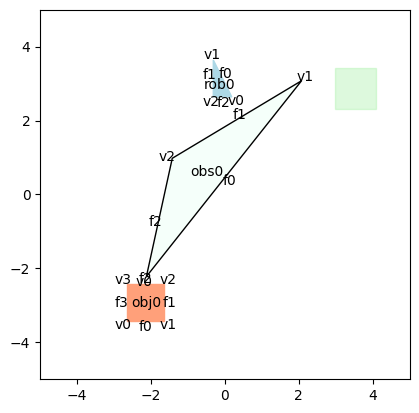

In [7]:
# Based on cg_maze_a35 but without the second obstacle
params = ContactGraphGeneratorParams(
    name='cg_maze_b2', 
    obs_vertices=[[[-2.124, -2.221],
        [2.076, 3.079],
        [-1.424, 0.979]]],
    
    obj_vertices=[[[1.000, 0.500],
        [1.000, -0.500],
        [2.000, -0.500],
        [2.000, 0.500]]],

    rob_vertices=[[[3.000, 1.000],
        [3.000, 0.000],
        [3.500, 0.000]]], 
    
    source_obj_pos=[[-2.137, -2.915]],
    source_rob_pos=[[-0.147, 2.973]], 
    n_pos_per_set=2,
    workspace=[[-5,  5],
       [-5,  5]], 
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [2.988, 2.325],
                [4.088, 2.325],
                [4.088, 3.425],
                [2.988, 3.425]
            ],
            obj_indices=[0],
            rob_indices=None
        )]
)
generator = ContactGraphGenerator(params)
generator.plot()

In [8]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 1059.70it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 46.38it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 631.23it/s]


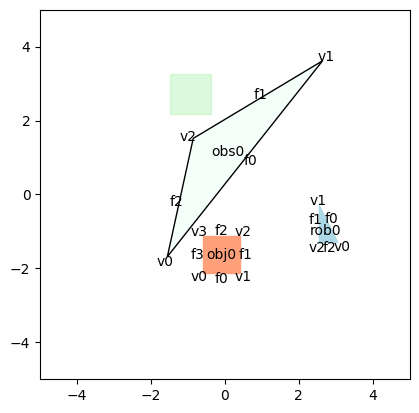

In [14]:
# Based on cg_maze_a39 but without the second obstacle

params = ContactGraphGeneratorParams(
    name='cg_maze_b3',
    obs_vertices=[
        [
            [-1.557, -1.683],
            [2.643, 3.617],
            [-0.857, 1.517]
        ]
    ],
    obj_vertices=[
        [
            [1.000, 0.500],
            [1.000, -0.500],
            [2.000, -0.500],
            [2.000, 0.500]
        ]
    ],
    rob_vertices=[
        [
            [3.000, 1.000],
            [3.000, 0.000],
            [3.500, 0.000]
        ]
    ],
    source_obj_pos=[[-0.104, -1.618]],
    source_rob_pos=[[2.723, -0.968]],
    n_pos_per_set=2,
    workspace=[
        [-5, 5],
        [-5, 5]
    ],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-1.477, 2.173],
                [-0.377, 2.173],
                [-0.377, 3.273],
                [-1.477, 3.273]
            ],
            obj_indices=[0],
            rob_indices=None
        )
    ]
)
generator = ContactGraphGenerator(params)
generator.plot()

In [15]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 18641.35it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9341.43it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 30.12it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 626.38it/s]


# StackPush

## StackPush a1 (2 objects)

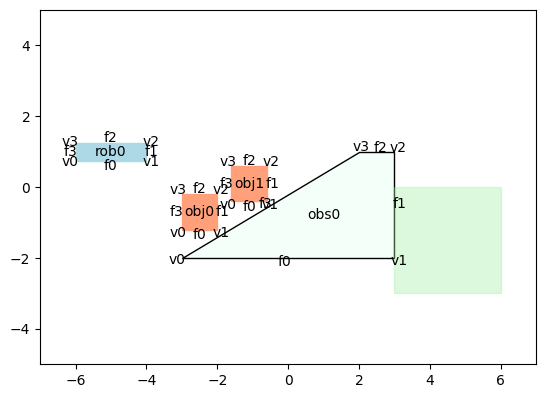

In [4]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## StackPush a2 (3 objects)

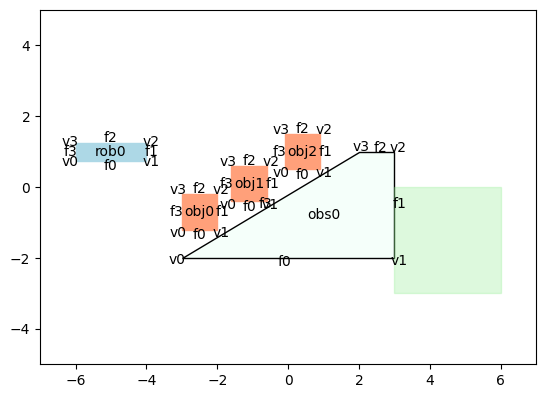

In [5]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a2",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Stackpush a3 (5 objects)

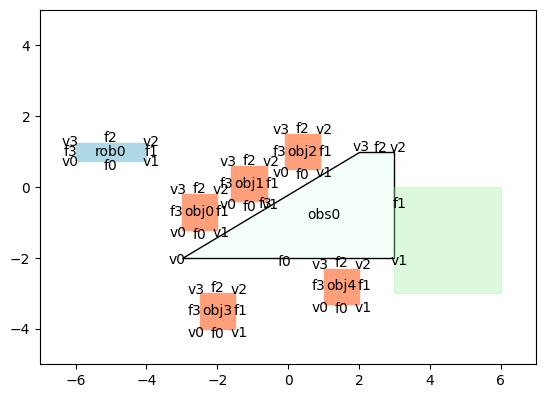

In [7]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a3",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1], [-2, -3.5], [1.5, -2.8]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [8]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 10754.63it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 4673.32it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 21 body pairs...
100%|██████████| 21/21 [00:00<00:00, 55.71it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (606)
100%|██████████| 606/606 [00:03<00:00, 200.60it/s]

Set parameter UsernameSet parameter Username
Set parameter Username
Set parameter Username

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use on


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 8802.32it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17586.18it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 21 body pairs...
100%|██████████| 21/21 [00:00<00:00, 59.36it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (606)
100%|██████████| 606/606 [00:03<00:00, 184.81it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04

## Stackpush a4 (9 objects)

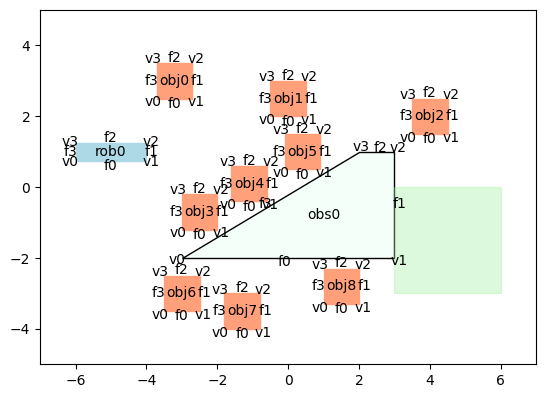

In [10]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a4",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[
        [-3.2, 3],
        [0, 2.5],
        [4, 2],
        [-2.5, -0.7],
        [-1.1, 0.1],
        [0.4, 1],
        [-3, -3],
        [-1.3, -3.5],
        [1.5, -2.8],
    ],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [11]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 33825.03it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6393.76it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 55 body pairs...
  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:01<00:00, 54.50it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (1590)
100%|██████████| 1590/1590 [00:03<00:00, 505.68it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use on


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 15857.48it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 20020.54it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 55 body pairs...
100%|██████████| 55/55 [00:01<00:00, 54.26it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (1590)
  1%|          | 8/1590 [00:03<08:15,  3.20it/s]  

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

100%|██████████| 1590/1590 [00:03<00:00, 453.87it/s]


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


# Radial Sort

## Radial Sort a1

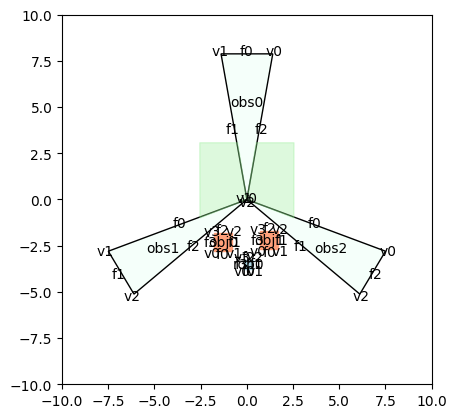

In [38]:
ws_x = 10
ws_y = 10
target_region_params = [
    ContactRegionParams(
        region_vertices=[[0, 0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]], obj_indices=[0]
    ),
    ContactRegionParams(
        region_vertices=[[0, 0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]],
        obj_indices=[1],
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a1",
    obs_vertices=[
        [[0, 0], [1.4, 7.88], [-1.4, 7.88]],
        [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
        [[0, 0], [7.5, -2.8], [6.11, -5.12]],
    ],
    obj_vertices=[box_obj_verts] * 2,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[
        [-1.3, -2.3],
        [1.2, -2.2],
    ],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [39]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 6825.56it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11491.24it/s]


INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 12 body pairs...
100%|██████████| 12/12 [00:00<00:00, 51.15it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (345)
100%|██████████| 345/345 [00:02<00:00, 118.40it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04Academic license - for non-commercial use only - expires 2024-03-04

Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04

## Radial Sort a2

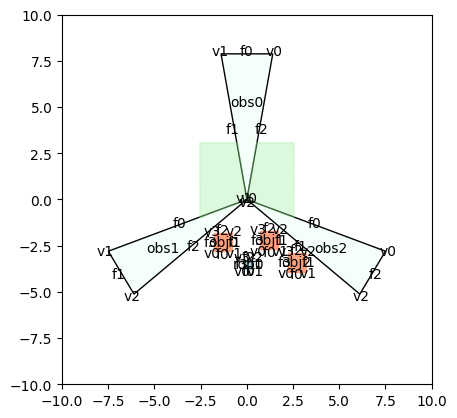

In [47]:
ws_x = 10
ws_y = 10
target_region_params = [
    # Right
    ContactRegionParams(
        region_vertices=[[0, 0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]],
        obj_indices=[0, 2],
    ),
    # Left
    ContactRegionParams(
        region_vertices=[[0, 0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]],
        obj_indices=[1],
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a2",
    obs_vertices=[
        [[0, 0], [1.4, 7.88], [-1.4, 7.88]],
        [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
        [[0, 0], [7.5, -2.8], [6.11, -5.12]],
    ],
    obj_vertices=[box_obj_verts] * 3,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[[-1.3, -2.3], [1.2, -2.2], [2.7, -3.4]],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [48]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 12354.36it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 18 body pairs...


100%|██████████| 18/18 [00:00<00:00, 56.72it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (555)
100%|██████████| 555/555 [00:02<00:00, 201.07it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04